<a href="https://colab.research.google.com/github/yhtang/SINN/blob/main/OU_SINN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Wed Jun 12 15:54:43 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA H100 PCIe               Off |   00000000:A8:00.0 Off |                    0 |
| N/A   40C    P0             81W /  350W |       0MiB /  81559MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [2]:
import itertools as it
import pickle
import torch
import torch.nn as nn
import torch.optim as optim
import torch.fft
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sdeint
from toolbox import (
    make_loss,
    StatLoss,
    SINN,
    FPU
)

In [3]:
device = torch.device('cuda')

In [4]:
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
torch.cuda.is_available()

True

In [6]:
print(torch.__version__)
print(torch.version.cuda)

2.0.1+cu118
11.8


In [7]:
seed = 1234
torch.set_default_dtype(torch.float)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)

320.0


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(800, 400) (800, 400)


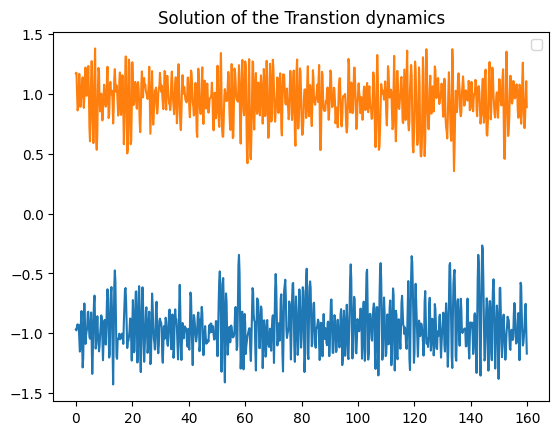

<Figure size 640x480 with 0 Axes>

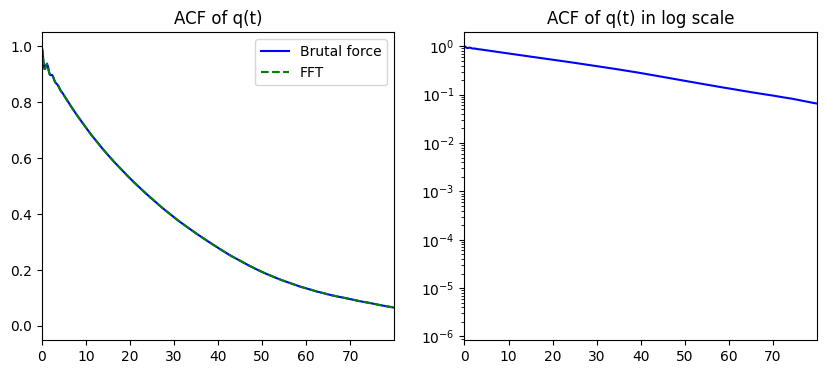

(400, 400) (400, 400)
CPU times: user 16.2 s, sys: 50.6 ms, total: 16.2 s
Wall time: 16.3 s


In [8]:
%%time

#### Generating SINN training data by solving the Langevin dynamics for the double-potential well

import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.integrate import quad

def V_FPU(x,U0,x0,sigma):
    v=U0/x0**4*x**3+U0/x0**2*x      # FPU potential 
    return v

def V_double_well(x,U0,x0,sigma):
    v=4*U0/x0**4*x**3-4*U0/x0**2*x+sigma/(2*x0)         # Double-well potential 
    return v 

def integrand(x,U0,x0,beta,sigma):
    v=np.exp(-beta*(U0*(1-(x/x0)**2)**2+sigma*x/(2*x0)))        # integrand function
    return v 

def integrand2(x,U0,x0,beta,sigma):
    v=x**2*np.exp(-beta*(U0*(1-(x/x0)**2)**2+sigma*x/(2*x0)))        # integrand function
    return v 

######## Paraemters 
gamma=1                   # Coupling constant 
beta=1                    # Inverse temperature, i.e. T=1/beta
U0=4                      # Depth of the well 
x0=1                      # Basin of the well
sigma=0                   # Asymmetry of the well 
dt=0.001                  # Step-size of the SDE solver 
delta_t=0.2               # Step-size of the temporally coarse-grained path
batch = 400               # Batch size 
sec_length = 400          # Length of the input sequence 
I=quad(integrand,-10,10,args=(U0,x0,beta,sigma))
I2=quad(integrand2,-10,10,args=(U0,x0,beta,sigma))   # PDF normalization constant (partition function) 

### SDE solver (EM scheme), 
Time = 4*delta_t*sec_length
print(Time)
length=int(Time/dt)+1
t = np.linspace(0,Time,length) # define time axis
gap=int(delta_t/dt)
t_store=t[0:-1:gap]
p_store = np.zeros([t_store.size+1,batch])
q_store = np.zeros([t_store.size+1,batch])
p=np.zeros((2,batch))
q=np.zeros((2,batch))
# solve SDE
j=1
for i in range(1,length):
     q[1,:] = q[0,:] + p[0,:]*dt
     p[1,:] = p[0,:] + (-V_double_well(q[0,:],U0,x0,sigma)-gamma*p[0,:])*dt + np.random.randn(1,batch)*np.sqrt(2*dt*gamma/beta)
     if i % gap ==0:            
            p_store[j,:]=p[1,:]
            q_store[j,:]=q[1,:]
            j=j+1
     p[0,:]=p[1,:]
     q[0,:]=q[1,:]

Toss=int(t_store.size/2)
p_store=p_store[Toss:-1,:]          
q_store=q_store[Toss:-1,:]         
print(p_store.shape,q_store.shape)




plt.figure(1)
for i in range(2):
    plt.plot(t_store[Toss:]-t_store[Toss],q_store[:,i])
plt.legend()
plt.title("Solution of the Transtion dynamics")


## Calculating the acf for q(t) by brutal force
Traj1=q_store
T_acf=t_store[0:Traj1.shape[0]]
acf_u=StatLoss.acf(torch.from_numpy(Traj1.reshape(Traj1.shape[0], batch,1)),method='bruteforce')
acf_u_fft=StatLoss.acf(torch.from_numpy(Traj1.reshape(Traj1.shape[0], batch,1)))
corr_u=acf_u.mean(axis=1).detach().cpu().numpy()
corr_u_fft=acf_u_fft.mean(axis=1).detach().cpu().numpy()
plt.figure(2)      
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
axs[0].plot(T_acf, corr_u,'b',label='Brutal force')
axs[0].plot(T_acf, corr_u_fft,'g--',label='FFT')
axs[0].set_title('ACF of q(t)')
axs[0].set_xlim([0,T_acf[-1]/2])
axs[0].legend()
axs[1].semilogy(T_acf, corr_u,'b')
axs[1].semilogy(T_acf, np.zeros([Traj1.shape[0],1]),'r')
axs[1].set_title('ACF of q(t) in log scale')
axs[1].set_xlim([0,T_acf[-1]/2])
plt.show()


#####################  Construct the sample traj for SINN learning 
ini=np.random.randn(sec_length,batch)
Traj=q_store[0:sec_length,:]
T=np.arange(len(Traj[:,1]))*delta_t
x=np.linspace(-5,5,sec_length)
pdf_exact=np.exp(-beta*(U0*(1-(x/x0)**2)**2+sigma*x/(2*x0)))/I[0]
print(ini.shape, Traj.shape)




In [9]:
# Reformulating data into Torch tensors 
# Input of SINN should be of the form (seq_len, batch, input_size)

ini = np.random.randn(2*sec_length,batch).astype(np.float32) 
input = torch.from_numpy(ini.reshape(2*sec_length, batch,1)).to(device)
batch_validation = batch
val_set = torch.normal(0.0, 1.0, (2*sec_length, batch_validation, 1), device=device)

# input of the LSTM should be of the form (seq_len, batch, input_size)
Traj = Traj.astype(np.float32) 
target = torch.from_numpy(Traj.reshape(sec_length, batch,1)).to(device)
pdf_exact = pdf_exact.astype(np.float32)
PDF_exact=torch.from_numpy(pdf_exact).to(device)
print('The torch input size is', input.size(), input.dtype)
print('The torch validation size is', val_set.size(), val_set.dtype)
print('The torch target size is', target.size(), target.dtype)

The torch input size is torch.Size([800, 400, 1]) torch.float32
The torch validation size is torch.Size([800, 400, 1]) torch.float32
The torch target size is torch.Size([400, 400, 1]) torch.float32


In [10]:
LAGS = 400
N = 400
loss_acf_fft = make_loss('acf[fft]', target, lags=LAGS, device=device)
loss_acf_q2 = make_loss('acf[fft]', target**2, lags=LAGS, device=device)
loss_acf_bruteforce = make_loss('acf[bruteforce]', target, lags=LAGS, device=device)
loss_acf_randbrute = make_loss('acf[randombrute]', target, lags=LAGS, sample_lags=20, device=device)
loss_pdf_empirical = make_loss('pdf', target, lower=-5, upper=5, n=N, bw=None, device=device)
loss_pdf_exact = make_loss('pdf', PDF_exact, lower=-5, upper=5, n=N, bw=None, device=device)

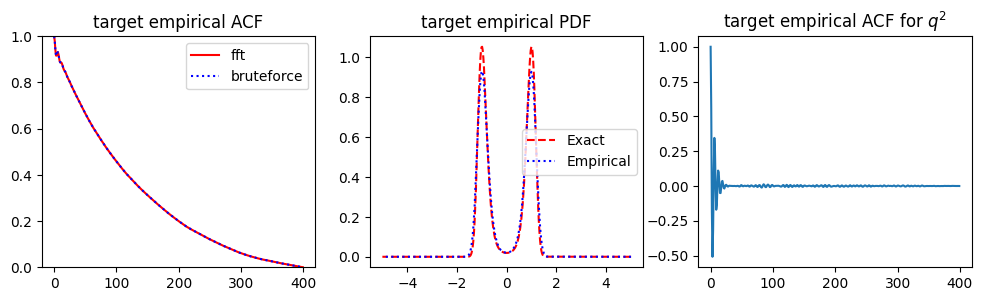

In [11]:
# Plotting target ACFs and PDF

fig, axs = plt.subplots(1, 3, figsize=(12, 3))
axs[0].plot(loss_acf_fft._target.cpu(),'r', label='fft')
axs[0].plot(loss_acf_bruteforce._target.cpu(),'b:', label='bruteforce')
axs[0].set_title('target empirical ACF')
axs[0].set_ylim([0,1])

x_grid=-np.linspace(-5,5,num=sec_length)
axs[1].plot(x_grid,loss_pdf_exact._target.cpu(),'r--', label='Exact')
axs[1].plot(x_grid,loss_pdf_empirical._target.cpu(),'b:', label='Empirical')
# axs[1].plot(x_grid, np.exp(-beta*(U0*(1-(x_grid/x0)**2)**2+sigma*x_grid/(2*x0)))/I[0],'r--')
axs[1].set_title('target empirical PDF')
axs[2].plot(loss_acf_q2._target.cpu())
axs[2].set_title(r'target empirical ACF for $q^2$')
axs[0].legend()
axs[1].legend()
plt.show()

In [12]:
### Defining SINN model 
net = SINN(1, 32, 2, 1,'LSTM').to(device)
optimizer = optim.Adam(net.parameters(), lr=1e-3)

In [13]:
from prettytable import PrettyTable

In [14]:
def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        params = parameter.numel()
        table.add_row([name, params])
        total_params+=params
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params

In [15]:
count_parameters(net)

+-------------------+------------+
|      Modules      | Parameters |
+-------------------+------------+
| arch.weight_ih_l0 |    128     |
| arch.weight_hh_l0 |    4096    |
|  arch.bias_ih_l0  |    128     |
|  arch.bias_hh_l0  |    128     |
| arch.weight_ih_l1 |    4096    |
| arch.weight_hh_l1 |    4096    |
|  arch.bias_ih_l1  |    128     |
|  arch.bias_hh_l1  |    128     |
|   readout.weight  |     32     |
|    readout.bias   |     1      |
+-------------------+------------+
Total Trainable Params: 12961


12961

In [16]:
%%time
# Training SINN
T_error=[]
V_error=[]
Step=[]
for step in range(20000):
    optimizer.zero_grad()
    ini = np.random.randn(2*sec_length,batch).astype(np.float32) 
    input = torch.from_numpy(ini.reshape(2*sec_length, batch,1)).to(device)
    prediction, _ = net(input)
    prediction = prediction[-LAGS:,:,:]
    loss = loss_acf_bruteforce(prediction) + loss_pdf_exact(prediction) + loss_acf_q2(prediction**2)
    loss.backward()
    optimizer.step()
    if step % 50 == 0: 
        with torch.no_grad():
            pred_val, _ = net(val_set)
            pred_val = pred_val[-LAGS:,:,:]
            loss_val = loss_acf_bruteforce(pred_val)+ loss_pdf_exact(pred_val) + loss_acf_q2(pred_val**2)
            loss_val_acf = loss_acf_fft(pred_val)
            print('[%d]-th step loss: %.3f, %.3f' % (step, loss, loss_val))
            T_error.append(loss.detach().cpu().numpy())
            V_error.append(loss_val.detach().cpu().numpy())
            Step.append(step)
    if loss<=0.05 and loss_val<=0.05:
        optimizer = optim.Adam(net.parameters(), lr=0.3*1e-3) 
    if loss<=0.01 and loss_val<=0.01:
        optimizer = optim.Adam(net.parameters(), lr=1e-4)    
    if loss<=0.005 and loss_val<=0.005:
        optimizer = optim.Adam(net.parameters(), lr=0.3*1e-4)
    if loss<=0.001 and loss_val<=0.001:
            break
print('Training finished')

[0]-th step loss: 0.523, 0.522
[50]-th step loss: 0.127, 0.115
[100]-th step loss: 0.046, 0.045
[150]-th step loss: 0.038, 0.031
[200]-th step loss: 0.020, 0.020
[250]-th step loss: 0.016, 0.016
[300]-th step loss: 0.013, 0.017
[350]-th step loss: 0.012, 0.010
[400]-th step loss: 0.008, 0.012
[450]-th step loss: 0.010, 0.007
[500]-th step loss: 0.006, 0.007
[550]-th step loss: 0.006, 0.007
[600]-th step loss: 0.006, 0.006
[650]-th step loss: 0.005, 0.006
[700]-th step loss: 0.005, 0.005
[750]-th step loss: 0.004, 0.004
[800]-th step loss: 0.004, 0.005
[850]-th step loss: 0.004, 0.004
[900]-th step loss: 0.004, 0.004
[950]-th step loss: 0.003, 0.004
[1000]-th step loss: 0.004, 0.004
[1050]-th step loss: 0.003, 0.004
[1100]-th step loss: 0.003, 0.003
[1150]-th step loss: 0.004, 0.004
[1200]-th step loss: 0.003, 0.003
[1250]-th step loss: 0.003, 0.003
[1300]-th step loss: 0.003, 0.003
[1350]-th step loss: 0.003, 0.003
[1400]-th step loss: 0.002, 0.003
[1450]-th step loss: 0.002, 0.003
[15

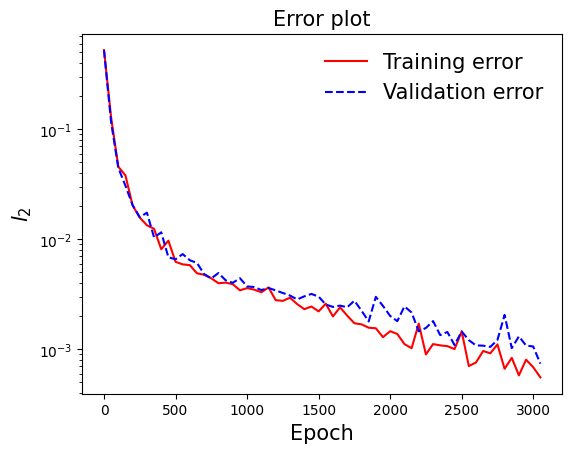

In [17]:
### Plotting the training and the generalization error
fig = plt.figure(1)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title("Error plot",fontsize=15) 
plt.semilogy(Step, T_error,'r',label='Training error')
plt.semilogy(Step, V_error,'b--',label='Validation error')
plt.xlabel('Epoch',fontsize=15)
plt.ylabel(r'$l_2$',fontsize=15)
plt.legend(frameon=False,fontsize=15)
# plt.savefig("figs/OU_training_error.pdf", dpi=150)

In [18]:
# # Constructing Gaussian random input
ran_input=torch.randn(input.size(),dtype=input.dtype,layout=input.layout, device=input.device)
Pred,_= net(ran_input)
prediction=Pred[-sec_length:,:,:].detach().cpu().numpy().reshape(sec_length, batch)

(array([-2. , -1.5, -1. , -0.5,  0. ,  0.5,  1. ,  1.5,  2. ]),
 [Text(0, -2.0, '−2.0'),
  Text(0, -1.5, '−1.5'),
  Text(0, -1.0, '−1.0'),
  Text(0, -0.5, '−0.5'),
  Text(0, 0.0, '0.0'),
  Text(0, 0.5, '0.5'),
  Text(0, 1.0, '1.0'),
  Text(0, 1.5, '1.5'),
  Text(0, 2.0, '2.0')])

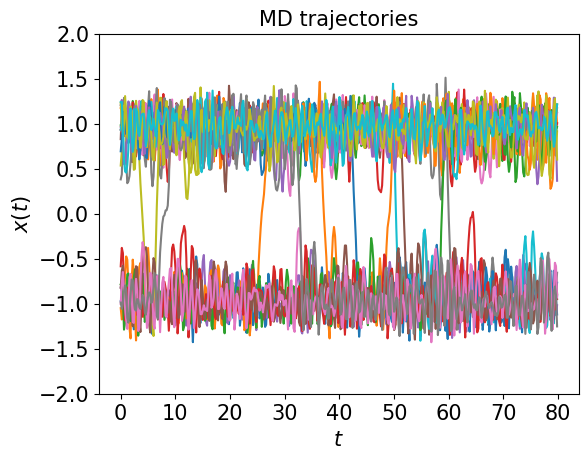

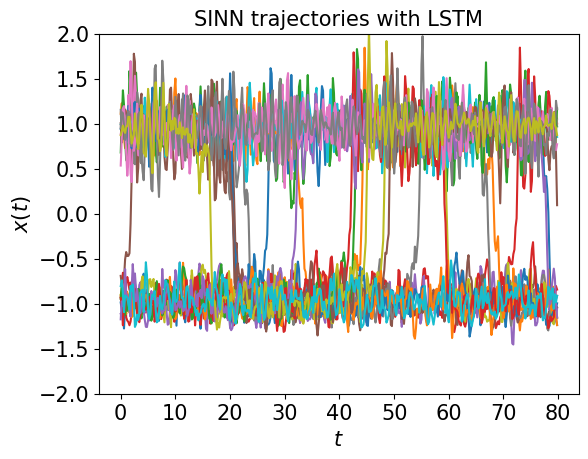

In [19]:
# Test 1: plot the sample path generated by SINN and the exact sample path 
skip = 0

fig = plt.figure(0)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title("MD trajectories",fontsize=15) 
# plt.plot(T[skip:]-T[skip], Traj[skip:, 0])
# plt.plot(T[skip:]-T[skip], Traj[skip:, 1])
# plt.plot(T[skip:]-T[skip], Traj[skip:, 2])
for i in range(20):
    plt.plot(T[skip:]-T[skip], Traj[skip:, i])   
plt.ylim([-2,2])
plt.xlabel(r'$t$',fontsize=15)
plt.ylabel(r'$x(t)$',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)     
# plt.savefig("figs/double_well_MD_traj_multi.pdf", dpi=150)


fig = plt.figure(1)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title("SINN trajectories with LSTM",fontsize=15)    
# plt.plot(T[skip:]-T[skip], prediction[skip:, 0])
# plt.plot(T[skip:]-T[skip], prediction[skip:, 1])
# plt.plot(T[skip:]-T[skip], prediction[skip:, 2])
for i in range(20):
    plt.plot(T[skip:]-T[skip], prediction[skip:, i])
plt.ylim([-2,2])
plt.xlabel(r'$t$',fontsize=15)
plt.ylabel(r'$x(t)$',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

400 torch.Size([800, 400, 1]) 400 400


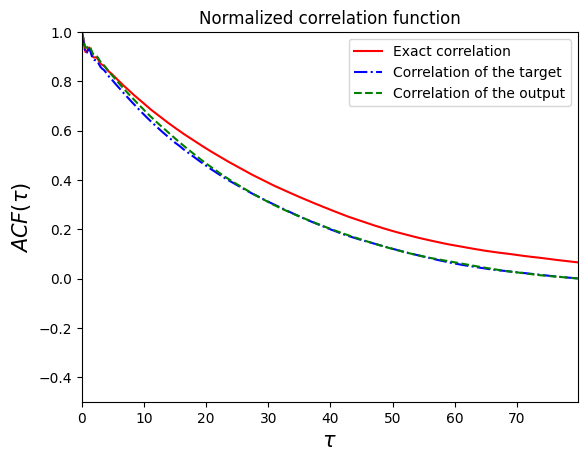

In [20]:
# Test 2: plot the ACF of the sample path generated by the SINN and the exact ACF  

acf_p=StatLoss.acf(Pred[-sec_length:,:,:],method='bruteforce')
acf_t=StatLoss.acf(target)
corr_p=acf_p.mean(axis=1).detach().cpu().numpy()
corr_t=acf_t.mean(axis=1).detach().cpu().numpy()

plt.figure(1)
plt.title("Normalized correlation function")    
plt.plot(T_acf, corr_u,'r',label='Exact correlation')               # Exact correlation function 
print(T.size, ran_input.size(), corr_t.size, corr_p.size)
plt.plot(T, corr_t,'b-.',label='Correlation of the target')         # Correlation function of the target 
plt.plot(T, corr_p, 'g--',label='Correlation of the output')        # Correlation function after the training 
plt.xlabel(r'$\tau$',fontsize=15)
plt.ylabel(r'$ACF(\tau)$',fontsize=15)
plt.ylim(-0.5,1)
plt.xlim(0,T[-1])
plt.legend()

tensor([-0.9684, -0.9753, -0.9406, -0.9251, -0.9557])
tensor([0.0133, 0.2230, 0.1218, 0.0818, 0.0023])


(array([0.  , 0.25, 0.5 , 0.75, 1.  , 1.25, 1.5 , 1.75, 2.  ]),
 [Text(0, 0.0, '0.00'),
  Text(0, 0.25, '0.25'),
  Text(0, 0.5, '0.50'),
  Text(0, 0.75, '0.75'),
  Text(0, 1.0, '1.00'),
  Text(0, 1.25, '1.25'),
  Text(0, 1.5, '1.50'),
  Text(0, 1.75, '1.75'),
  Text(0, 2.0, '2.00')])

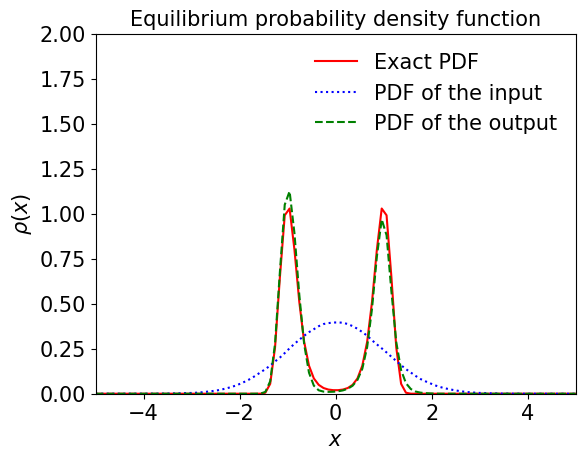

In [21]:
# Test 3: plot the PDF of the sample path generated by SINN and the exact PDF  
rho_data =  StatLoss.gauss_kde(target, -5, 5, 100, None).cpu()
rho_input = StatLoss.gauss_kde(ran_input, -5, 5, 100, None).cpu()
rho_prediction = StatLoss.gauss_kde(Pred[-sec_length:,:,:].detach(), -5, 5, 100, None).cpu()
print(target.detach().cpu()[0:5,0,0])
print(Pred.detach().cpu()[0:5,0,0])

x=np.linspace(-5, 5, 100)
fig = plt.figure(0)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title("Equilibrium probability density function",fontsize=15)    
# plt.plot(x, rho_data.numpy(), 'r',label='PDF of the target')    # target PDF
plt.plot(x, np.exp(-beta*(U0*(1-(x/x0)**2)**2+sigma*x/(2*x0)))/I[0], 'r',label='Exact PDF') 
plt.plot(x, rho_input.numpy(), 'b:', label='PDF of the input')     # PDF of the input
plt.plot(x, rho_prediction.numpy(), 'g--',label='PDF of the output')  # PDF after the training 
plt.xlim(-5,5)
plt.ylim(0,2)
plt.xlabel(r'$x$',fontsize=15)
plt.ylabel(r'$\rho(x)$',fontsize=15)
plt.legend(frameon=False,fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

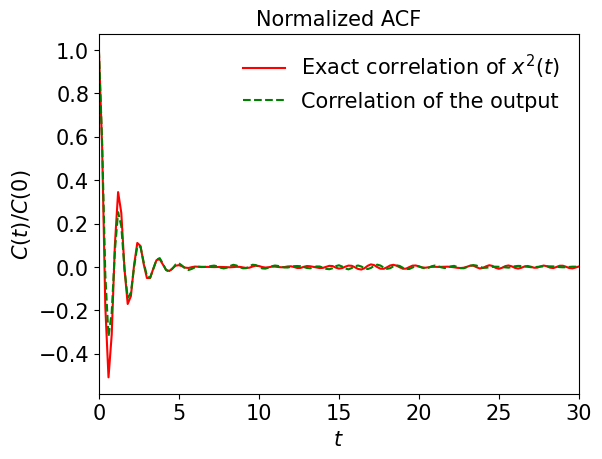

In [22]:
# Test 4: Comparing the higher-order ACF
acf2=StatLoss.acf(target**2)
pred_norm=torch.from_numpy((prediction).reshape(sec_length, batch,1))
acf2_app=StatLoss.acf(pred_norm**2)

fig = plt.figure(0)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title(r'Normalized ACF',fontsize=15)    
plt.plot(T, acf2.mean(axis=1).detach().cpu().numpy(),'r',label=r'Exact correlation of $x^2(t)$')        # Exact correlation function 
plt.plot(T, acf2_app.mean(axis=1).detach().cpu().numpy(), 'g--',label=r'Correlation of the output')        # Correlation function after the training 
plt.xlim(0,30)
plt.xlabel(r'$t$',fontsize=15)
plt.ylabel(r'$C(t)/C(0)$',fontsize=15)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.legend(frameon=False,fontsize=15)
# plt.savefig("figs/double_well_acf2.pdf", dpi=150)



In [23]:
# # Test 4: Comparing the higher-order ACF
# acf2=StatLoss.acf(target**2)
# pred_norm=torch.from_numpy((prediction).reshape(sec_length, batch,1))
# acf2_app=StatLoss.acf(pred_norm**2)

# fig = plt.figure(0)
# ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
# plt.title(r'Normalized ACF',fontsize=15)    
# plt.plot(T, acf2.mean(axis=1).detach().cpu().numpy(),'r',label=r'Exact correlation of $x^2(t)$')        # Exact correlation function 
# plt.plot(T, acf2_app.mean(axis=1).detach().cpu().numpy(), 'g--',label=r'Correlation of the output')        # Correlation function after the training 
# # plt.xlim(0,30)
# plt.xlabel(r'$\tau$',fontsize=15)
# plt.ylabel(r'$C(\tau)/C(0)$',fontsize=15)
# plt.xticks(fontsize=15)
# plt.yticks([-0.2,0,0.2,0.4,0.6,0.8,1.0],fontsize=15)
# plt.legend(frameon=False,fontsize=15)
# # plt.savefig("figs/OU_acf2.pdf", dpi=150)

(array([  0., 100., 200., 300., 400., 500.]),
 [Text(0.0, 0, '0'),
  Text(100.0, 0, '100'),
  Text(200.0, 0, '200'),
  Text(300.0, 0, '300'),
  Text(400.0, 0, '400'),
  Text(500.0, 0, '500')])

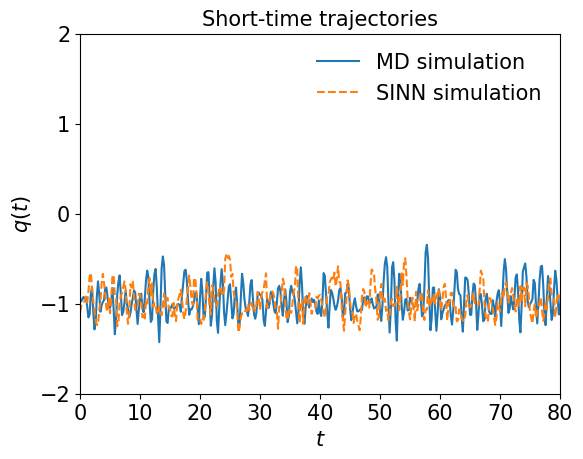

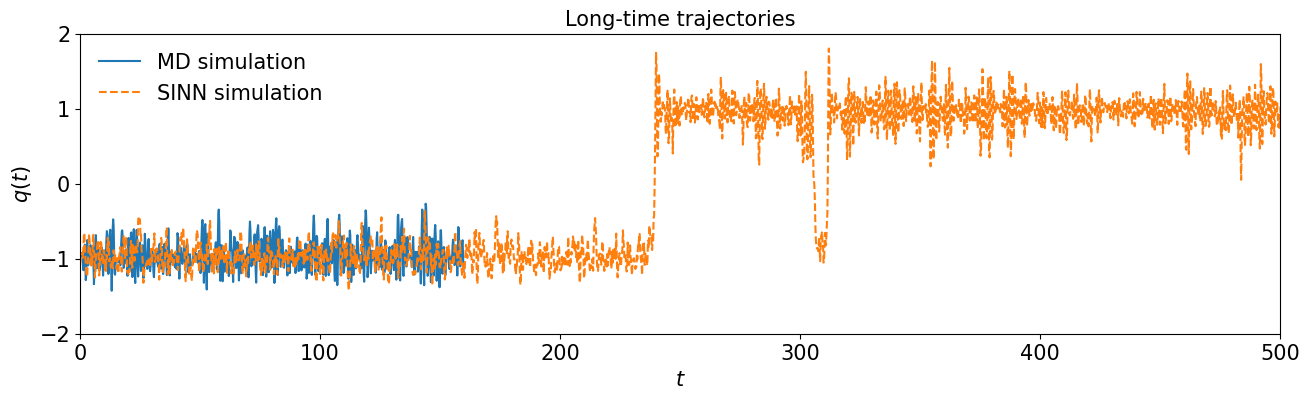

In [24]:
# Test 5: plot the expolation result, i.e. Prediction of the OU dynamics for longer time 

[a,b,c]=input.size()
skip=20
scale=10
burnin=3
fold=800
batch_new=50
ran_input=torch.randn(((scale-burnin)*a,batch_new,c),dtype=input.dtype,layout=input.layout, device=input.device)
Pred_L, _= net(ran_input)
prediction_ext=Pred_L.detach().cpu().numpy().reshape((scale-burnin)*a, batch_new)
acf_p=StatLoss.acf(Pred_L,method='bruteforce')

LT=np.linspace(0,(scale-burnin)*a*delta_t,num=(scale-burnin)*a+1)
LT=LT[0:-1]


fig = plt.figure(0)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title("Short-time trajectories",fontsize=15)
plt.plot(t_store[Toss:]-t_store[Toss],q_store[:,0],label='MD simulation')
plt.plot(LT[skip:]-LT[skip], prediction_ext[skip:, 1],'--',label='SINN simulation')
plt.xlim([0,80])
plt.ylim([-2,2])
plt.xlabel(r'$t$',fontsize=15)
plt.ylabel(r'$q(t)$',fontsize=15)
plt.legend(frameon=False,fontsize=15)
plt.yticks([-2,-1,0,1,2],fontsize=15)
plt.xticks(fontsize=15)
# plt.savefig("figs/OU_traj_sT.pdf", dpi=150)


fig = plt.figure(figsize=(16, 4))
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title("Long-time trajectories",fontsize=15)
plt.plot(t_store[Toss:]-t_store[Toss],q_store[:,0],label='MD simulation')
plt.plot(LT[skip:]-LT[skip], prediction_ext[skip:, 1],'--',label='SINN simulation')
plt.xlim([0,500])
plt.ylim([-2,2])
plt.xlabel(r'$t$',fontsize=15)
plt.ylabel(r'$q(t)$',fontsize=15)
plt.legend(frameon=False,fontsize=15)
plt.yticks([-2,-1,0,1,2],fontsize=15)
plt.xticks(fontsize=15)
# plt.savefig("figs/OU_traj_lT.pdf", dpi=150)

In [25]:
### Defining SINN model 
net1 = SINN(1, 32, 2, 1,'LSTM').to(device)
optimizer = optim.Adam(net1.parameters(), lr=1e-3)

In [26]:
%%time
# Training SINN
T_error=[]
V_error=[]
Step=[]
for step in range(20000):
    optimizer.zero_grad()
    ini = np.random.randn(2*sec_length,batch).astype(np.float32) 
    input = torch.from_numpy(ini.reshape(2*sec_length, batch,1)).to(device)
    prediction, _ = net1(input)
    prediction = prediction[-LAGS:,:,:]
    loss = loss_acf_bruteforce(prediction) + loss_pdf_exact(prediction) + loss_acf_q2(prediction**2)
    loss.backward()
    optimizer.step()
    if step % 50 == 0: 
        with torch.no_grad():
            pred_val, _ = net1(val_set)
            pred_val = pred_val[-LAGS:,:,:]
            loss_val = loss_acf_bruteforce(pred_val)+ loss_pdf_exact(pred_val) + loss_acf_q2(pred_val**2)
            loss_val_acf = loss_acf_fft(pred_val)
            print('[%d]-th step loss: %.3f, %.3f' % (step, loss, loss_val))
            T_error.append(loss.detach().cpu().numpy())
            V_error.append(loss_val.detach().cpu().numpy())
            Step.append(step)
    if loss<=0.05 and loss_val<=0.05:
        optimizer = optim.Adam(net1.parameters(), lr=0.3*1e-3) 
    if loss<=0.01 and loss_val<=0.01:
        optimizer = optim.Adam(net1.parameters(), lr=1e-4)    
    if loss<=0.005 and loss_val<=0.005:
        optimizer = optim.Adam(net1.parameters(), lr=0.3*1e-4)
    if loss<=0.001 and loss_val<=0.001:
            break
print('Training finished')

[0]-th step loss: 0.524, 0.523
[50]-th step loss: 0.113, 0.101
[100]-th step loss: 0.131, 0.171
[150]-th step loss: 0.100, 0.094
[200]-th step loss: 0.071, 0.070
[250]-th step loss: 0.050, 0.051
[300]-th step loss: 0.040, 0.042
[350]-th step loss: 0.032, 0.039
[400]-th step loss: 0.034, 0.031
[450]-th step loss: 0.031, 0.029
[500]-th step loss: 0.027, 0.026
[550]-th step loss: 0.024, 0.023
[600]-th step loss: 0.021, 0.018
[650]-th step loss: 0.015, 0.015
[700]-th step loss: 0.014, 0.017
[750]-th step loss: 0.010, 0.010
[800]-th step loss: 0.008, 0.011
[850]-th step loss: 0.007, 0.013
[900]-th step loss: 0.009, 0.007
[950]-th step loss: 0.006, 0.008
[1000]-th step loss: 0.007, 0.007
[1050]-th step loss: 0.006, 0.007
[1100]-th step loss: 0.007, 0.006
[1150]-th step loss: 0.005, 0.008
[1200]-th step loss: 0.008, 0.006
[1250]-th step loss: 0.005, 0.006
[1300]-th step loss: 0.006, 0.007
[1350]-th step loss: 0.005, 0.006
[1400]-th step loss: 0.005, 0.005
[1450]-th step loss: 0.005, 0.005
[15

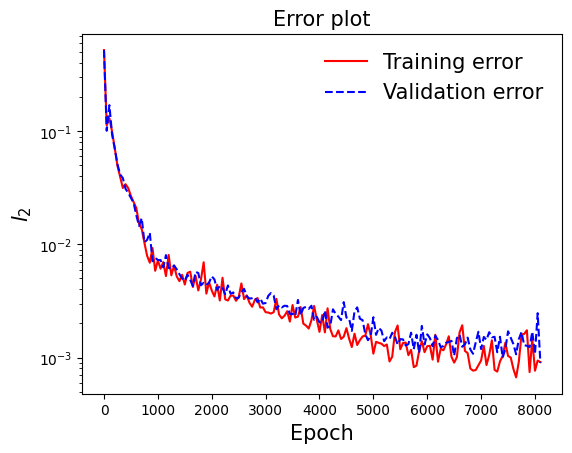

In [27]:
### Plotting the training and the generalization error
fig = plt.figure(1)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title("Error plot",fontsize=15) 
plt.semilogy(Step, T_error,'r',label='Training error')
plt.semilogy(Step, V_error,'b--',label='Validation error')
plt.xlabel('Epoch',fontsize=15)
plt.ylabel(r'$l_2$',fontsize=15)
plt.legend(frameon=False,fontsize=15)

In [28]:
### Defining SINN model 
net2 = SINN(1, 32, 2, 1,'LSTM').to(device)
optimizer = optim.Adam(net2.parameters(), lr=1e-3)

In [29]:
%%time
# Training SINN
T_error=[]
V_error=[]
Step=[]
for step in range(20000):
    optimizer.zero_grad()
    ini = np.random.randn(2*sec_length,batch).astype(np.float32) 
    input = torch.from_numpy(ini.reshape(2*sec_length, batch,1)).to(device)
    prediction, _ = net2(input)
    prediction = prediction[-LAGS:,:,:]
    loss = loss_acf_bruteforce(prediction) + loss_pdf_exact(prediction) + loss_acf_q2(prediction**2)
    loss.backward()
    optimizer.step()
    if step % 50 == 0: 
        with torch.no_grad():
            pred_val, _ = net2(val_set)
            pred_val = pred_val[-LAGS:,:,:]
            loss_val = loss_acf_bruteforce(pred_val)+ loss_pdf_exact(pred_val) + loss_acf_q2(pred_val**2)
            loss_val_acf = loss_acf_fft(pred_val)
            print('[%d]-th step loss: %.3f, %.3f' % (step, loss, loss_val))
            T_error.append(loss.detach().cpu().numpy())
            V_error.append(loss_val.detach().cpu().numpy())
            Step.append(step)
    if loss<=0.05 and loss_val<=0.05:
        optimizer = optim.Adam(net2.parameters(), lr=0.3*1e-3) 
    if loss<=0.01 and loss_val<=0.01:
        optimizer = optim.Adam(net2.parameters(), lr=1e-4)    
    if loss<=0.005 and loss_val<=0.005:
        optimizer = optim.Adam(net2.parameters(), lr=0.3*1e-4)
    if loss<=0.001 and loss_val<=0.001:
            break
print('Training finished')

[0]-th step loss: 0.524, 0.521
[50]-th step loss: 0.159, 0.155
[100]-th step loss: 0.160, 0.147
[150]-th step loss: 0.064, 0.061
[200]-th step loss: 0.184, 0.192
[250]-th step loss: 0.173, 0.166
[300]-th step loss: 0.021, 0.023
[350]-th step loss: 0.016, 0.015
[400]-th step loss: 0.016, 0.019
[450]-th step loss: 0.013, 0.013
[500]-th step loss: 0.013, 0.012
[550]-th step loss: 0.012, 0.010
[600]-th step loss: 0.009, 0.011
[650]-th step loss: 0.008, 0.013
[700]-th step loss: 0.008, 0.017
[750]-th step loss: 0.008, 0.008
[800]-th step loss: 0.007, 0.007
[850]-th step loss: 0.006, 0.006
[900]-th step loss: 0.006, 0.006
[950]-th step loss: 0.005, 0.006
[1000]-th step loss: 0.005, 0.006
[1050]-th step loss: 0.005, 0.006
[1100]-th step loss: 0.004, 0.004
[1150]-th step loss: 0.004, 0.005
[1200]-th step loss: 0.004, 0.005
[1250]-th step loss: 0.004, 0.005
[1300]-th step loss: 0.004, 0.005
[1350]-th step loss: 0.004, 0.005
[1400]-th step loss: 0.003, 0.004
[1450]-th step loss: 0.004, 0.005
[15

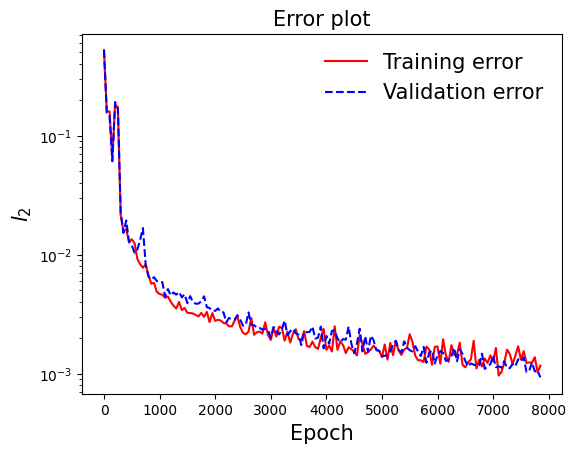

In [30]:
### Plotting the training and the generalization error
fig = plt.figure(1)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title("Error plot",fontsize=15) 
plt.semilogy(Step, T_error,'r',label='Training error')
plt.semilogy(Step, V_error,'b--',label='Validation error')
plt.xlabel('Epoch',fontsize=15)
plt.ylabel(r'$l_2$',fontsize=15)
plt.legend(frameon=False,fontsize=15)

In [31]:
### Defining SINN model 
net3 = SINN(1, 32, 2, 1,'LSTM').to(device)
optimizer = optim.Adam(net3.parameters(), lr=1e-3)

In [32]:
%%time
# Training SINN
T_error=[]
V_error=[]
Step=[]
for step in range(20000):
    optimizer.zero_grad()
    ini = np.random.randn(2*sec_length,batch).astype(np.float32) 
    input = torch.from_numpy(ini.reshape(2*sec_length, batch,1)).to(device)
    prediction, _ = net3(input)
    prediction = prediction[-LAGS:,:,:]
    loss = loss_acf_bruteforce(prediction) + loss_pdf_exact(prediction) + loss_acf_q2(prediction**2)
    loss.backward()
    optimizer.step()
    if step % 50 == 0: 
        with torch.no_grad():
            pred_val, _ = net3(val_set)
            pred_val = pred_val[-LAGS:,:,:]
            loss_val = loss_acf_bruteforce(pred_val)+ loss_pdf_exact(pred_val) + loss_acf_q2(pred_val**2)
            loss_val_acf = loss_acf_fft(pred_val)
            print('[%d]-th step loss: %.3f, %.3f' % (step, loss, loss_val))
            T_error.append(loss.detach().cpu().numpy())
            V_error.append(loss_val.detach().cpu().numpy())
            Step.append(step)
    if loss<=0.05 and loss_val<=0.05:
        optimizer = optim.Adam(net3.parameters(), lr=0.3*1e-3) 
    if loss<=0.01 and loss_val<=0.01:
        optimizer = optim.Adam(net3.parameters(), lr=1e-4)    
    if loss<=0.005 and loss_val<=0.005:
        optimizer = optim.Adam(net3.parameters(), lr=0.3*1e-4)
    if loss<=0.001 and loss_val<=0.001:
            break
print('Training finished')

[0]-th step loss: 0.525, 0.522
[50]-th step loss: 0.202, 0.196
[100]-th step loss: 0.133, 0.116
[150]-th step loss: 0.045, 0.046
[200]-th step loss: 0.016, 0.017
[250]-th step loss: 0.014, 0.021
[300]-th step loss: 0.012, 0.014
[350]-th step loss: 0.015, 0.016
[400]-th step loss: 0.010, 0.015
[450]-th step loss: 0.010, 0.012
[500]-th step loss: 0.011, 0.012
[550]-th step loss: 0.012, 0.009
[600]-th step loss: 0.007, 0.007
[650]-th step loss: 0.009, 0.008
[700]-th step loss: 0.006, 0.009
[750]-th step loss: 0.006, 0.009
[800]-th step loss: 0.008, 0.009
[850]-th step loss: 0.006, 0.006
[900]-th step loss: 0.006, 0.005
[950]-th step loss: 0.005, 0.005
[1000]-th step loss: 0.005, 0.006
[1050]-th step loss: 0.005, 0.005
[1100]-th step loss: 0.006, 0.005
[1150]-th step loss: 0.005, 0.005
[1200]-th step loss: 0.004, 0.005
[1250]-th step loss: 0.004, 0.005
[1300]-th step loss: 0.006, 0.005
[1350]-th step loss: 0.004, 0.004
[1400]-th step loss: 0.004, 0.005
[1450]-th step loss: 0.004, 0.004
[15

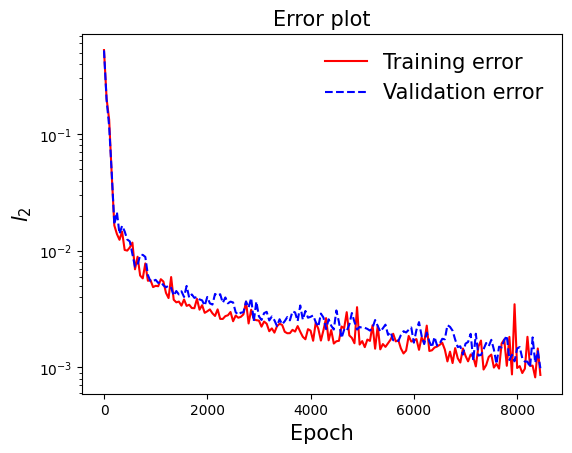

In [33]:
### Plotting the training and the generalization error
fig = plt.figure(1)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title("Error plot",fontsize=15) 
plt.semilogy(Step, T_error,'r',label='Training error')
plt.semilogy(Step, V_error,'b--',label='Validation error')
plt.xlabel('Epoch',fontsize=15)
plt.ylabel(r'$l_2$',fontsize=15)
plt.legend(frameon=False,fontsize=15)

In [34]:
### Defining SINN model 
net4 = SINN(1, 32, 2, 1,'LSTM').to(device)
optimizer = optim.Adam(net4.parameters(), lr=1e-3)

In [35]:
%%time
# Training SINN
T_error=[]
V_error=[]
Step=[]
for step in range(20000):
    optimizer.zero_grad()
    ini = np.random.randn(2*sec_length,batch).astype(np.float32) 
    input = torch.from_numpy(ini.reshape(2*sec_length, batch,1)).to(device)
    prediction, _ = net4(input)
    prediction = prediction[-LAGS:,:,:]
    loss = loss_acf_bruteforce(prediction) + loss_pdf_exact(prediction) + loss_acf_q2(prediction**2)
    loss.backward()
    optimizer.step()
    if step % 50 == 0: 
        with torch.no_grad():
            pred_val, _ = net4(val_set)
            pred_val = pred_val[-LAGS:,:,:]
            loss_val = loss_acf_bruteforce(pred_val)+ loss_pdf_exact(pred_val) + loss_acf_q2(pred_val**2)
            loss_val_acf = loss_acf_fft(pred_val)
            print('[%d]-th step loss: %.3f, %.3f' % (step, loss, loss_val))
            T_error.append(loss.detach().cpu().numpy())
            V_error.append(loss_val.detach().cpu().numpy())
            Step.append(step)
    if loss<=0.05 and loss_val<=0.05:
        optimizer = optim.Adam(net4.parameters(), lr=0.3*1e-3) 
    if loss<=0.01 and loss_val<=0.01:
        optimizer = optim.Adam(net4.parameters(), lr=1e-4)    
    if loss<=0.005 and loss_val<=0.005:
        optimizer = optim.Adam(net4.parameters(), lr=0.3*1e-4)
    if loss<=0.001 and loss_val<=0.001:
            break
print('Training finished')

[0]-th step loss: 0.524, 0.523
[50]-th step loss: 0.121, 0.118
[100]-th step loss: 0.133, 0.133
[150]-th step loss: 0.023, 0.026
[200]-th step loss: 0.015, 0.013
[250]-th step loss: 0.014, 0.016
[300]-th step loss: 0.013, 0.013
[350]-th step loss: 0.011, 0.010
[400]-th step loss: 0.014, 0.013
[450]-th step loss: 0.009, 0.010
[500]-th step loss: 0.009, 0.008
[550]-th step loss: 0.008, 0.008
[600]-th step loss: 0.007, 0.008
[650]-th step loss: 0.006, 0.007
[700]-th step loss: 0.006, 0.007
[750]-th step loss: 0.006, 0.008
[800]-th step loss: 0.007, 0.008
[850]-th step loss: 0.005, 0.006
[900]-th step loss: 0.005, 0.005
[950]-th step loss: 0.005, 0.005
[1000]-th step loss: 0.005, 0.005
[1050]-th step loss: 0.004, 0.005
[1100]-th step loss: 0.004, 0.005
[1150]-th step loss: 0.004, 0.005
[1200]-th step loss: 0.004, 0.004
[1250]-th step loss: 0.004, 0.004
[1300]-th step loss: 0.004, 0.004
[1350]-th step loss: 0.003, 0.005
[1400]-th step loss: 0.003, 0.004
[1450]-th step loss: 0.004, 0.004
[15

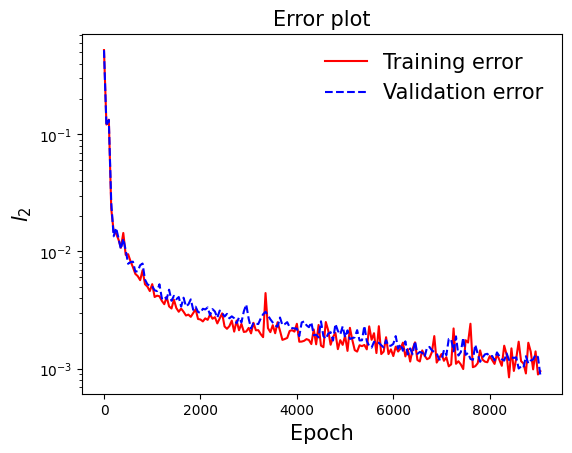

In [36]:
### Plotting the training and the generalization error
fig = plt.figure(1)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title("Error plot",fontsize=15) 
plt.semilogy(Step, T_error,'r',label='Training error')
plt.semilogy(Step, V_error,'b--',label='Validation error')
plt.xlabel('Epoch',fontsize=15)
plt.ylabel(r'$l_2$',fontsize=15)
plt.legend(frameon=False,fontsize=15)

In [37]:
### Defining SINN model 
net5 = SINN(1, 32, 2, 1,'LSTM').to(device)
optimizer = optim.Adam(net5.parameters(), lr=1e-3)

In [38]:
%%time
# Training SINN
T_error=[]
V_error=[]
Step=[]
for step in range(20000):
    optimizer.zero_grad()
    ini = np.random.randn(2*sec_length,batch).astype(np.float32) 
    input = torch.from_numpy(ini.reshape(2*sec_length, batch,1)).to(device)
    prediction, _ = net5(input)
    prediction = prediction[-LAGS:,:,:]
    loss = loss_acf_bruteforce(prediction) + loss_pdf_exact(prediction) + loss_acf_q2(prediction**2)
    loss.backward()
    optimizer.step()
    if step % 50 == 0: 
        with torch.no_grad():
            pred_val, _ = net5(val_set)
            pred_val = pred_val[-LAGS:,:,:]
            loss_val = loss_acf_bruteforce(pred_val)+ loss_pdf_exact(pred_val) + loss_acf_q2(pred_val**2)
            loss_val_acf = loss_acf_fft(pred_val)
            print('[%d]-th step loss: %.3f, %.3f' % (step, loss, loss_val))
            T_error.append(loss.detach().cpu().numpy())
            V_error.append(loss_val.detach().cpu().numpy())
            Step.append(step)
    if loss<=0.05 and loss_val<=0.05:
        optimizer = optim.Adam(net5.parameters(), lr=0.3*1e-3) 
    if loss<=0.01 and loss_val<=0.01:
        optimizer = optim.Adam(net5.parameters(), lr=1e-4)    
    if loss<=0.005 and loss_val<=0.005:
        optimizer = optim.Adam(net5.parameters(), lr=0.3*1e-4)
    if loss<=0.001 and loss_val<=0.001:
            break
print('Training finished')

[0]-th step loss: 0.527, 0.524
[50]-th step loss: 0.143, 0.133
[100]-th step loss: 0.018, 0.018
[150]-th step loss: 0.016, 0.018
[200]-th step loss: 0.013, 0.019
[250]-th step loss: 0.012, 0.019
[300]-th step loss: 0.014, 0.013
[350]-th step loss: 0.012, 0.014
[400]-th step loss: 0.010, 0.009
[450]-th step loss: 0.009, 0.008
[500]-th step loss: 0.011, 0.009
[550]-th step loss: 0.008, 0.008
[600]-th step loss: 0.007, 0.009
[650]-th step loss: 0.007, 0.007
[700]-th step loss: 0.007, 0.006
[750]-th step loss: 0.006, 0.007
[800]-th step loss: 0.006, 0.006
[850]-th step loss: 0.005, 0.006
[900]-th step loss: 0.005, 0.006
[950]-th step loss: 0.005, 0.005
[1000]-th step loss: 0.005, 0.005
[1050]-th step loss: 0.005, 0.005
[1100]-th step loss: 0.005, 0.005
[1150]-th step loss: 0.004, 0.004
[1200]-th step loss: 0.004, 0.005
[1250]-th step loss: 0.004, 0.004
[1300]-th step loss: 0.004, 0.005
[1350]-th step loss: 0.004, 0.005
[1400]-th step loss: 0.004, 0.005
[1450]-th step loss: 0.003, 0.004
[15

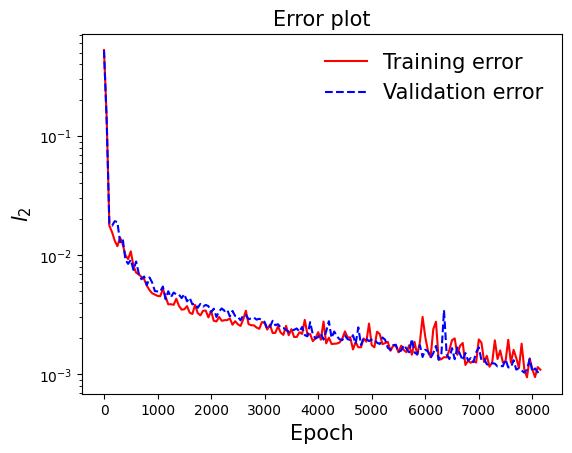

In [39]:
### Plotting the training and the generalization error
fig = plt.figure(1)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title("Error plot",fontsize=15) 
plt.semilogy(Step, T_error,'r',label='Training error')
plt.semilogy(Step, V_error,'b--',label='Validation error')
plt.xlabel('Epoch',fontsize=15)
plt.ylabel(r'$l_2$',fontsize=15)
plt.legend(frameon=False,fontsize=15)

In [40]:
### Defining SINN model 
net6 = SINN(1, 32, 2, 1,'LSTM').to(device)
optimizer = optim.Adam(net6.parameters(), lr=1e-3)

In [41]:
%%time
# Training SINN
T_error=[]
V_error=[]
Step=[]
for step in range(20000):
    optimizer.zero_grad()
    ini = np.random.randn(2*sec_length,batch).astype(np.float32) 
    input = torch.from_numpy(ini.reshape(2*sec_length, batch,1)).to(device)
    prediction, _ = net6(input)
    prediction = prediction[-LAGS:,:,:]
    loss = loss_acf_bruteforce(prediction) + loss_pdf_exact(prediction) + loss_acf_q2(prediction**2)
    loss.backward()
    optimizer.step()
    if step % 50 == 0: 
        with torch.no_grad():
            pred_val, _ = net6(val_set)
            pred_val = pred_val[-LAGS:,:,:]
            loss_val = loss_acf_bruteforce(pred_val)+ loss_pdf_exact(pred_val) + loss_acf_q2(pred_val**2)
            loss_val_acf = loss_acf_fft(pred_val)
            print('[%d]-th step loss: %.3f, %.3f' % (step, loss, loss_val))
            T_error.append(loss.detach().cpu().numpy())
            V_error.append(loss_val.detach().cpu().numpy())
            Step.append(step)
    if loss<=0.05 and loss_val<=0.05:
        optimizer = optim.Adam(net6.parameters(), lr=0.3*1e-3) 
    if loss<=0.01 and loss_val<=0.01:
        optimizer = optim.Adam(net6.parameters(), lr=1e-4)    
    if loss<=0.005 and loss_val<=0.005:
        optimizer = optim.Adam(net6.parameters(), lr=0.3*1e-4)
    if loss<=0.001 and loss_val<=0.001:
            break
print('Training finished')

[0]-th step loss: 0.524, 0.523
[50]-th step loss: 0.197, 0.194
[100]-th step loss: 0.059, 0.051
[150]-th step loss: 0.024, 0.029
[200]-th step loss: 0.014, 0.015
[250]-th step loss: 0.013, 0.014
[300]-th step loss: 0.013, 0.020
[350]-th step loss: 0.012, 0.016
[400]-th step loss: 0.018, 0.011
[450]-th step loss: 0.012, 0.013
[500]-th step loss: 0.010, 0.014
[550]-th step loss: 0.008, 0.013
[600]-th step loss: 0.008, 0.009
[650]-th step loss: 0.007, 0.008
[700]-th step loss: 0.007, 0.007
[750]-th step loss: 0.006, 0.007
[800]-th step loss: 0.006, 0.007
[850]-th step loss: 0.006, 0.006
[900]-th step loss: 0.005, 0.006
[950]-th step loss: 0.005, 0.006
[1000]-th step loss: 0.005, 0.006
[1050]-th step loss: 0.005, 0.005
[1100]-th step loss: 0.004, 0.005
[1150]-th step loss: 0.004, 0.005
[1200]-th step loss: 0.004, 0.004
[1250]-th step loss: 0.004, 0.005
[1300]-th step loss: 0.004, 0.004
[1350]-th step loss: 0.004, 0.004
[1400]-th step loss: 0.004, 0.004
[1450]-th step loss: 0.005, 0.004
[15

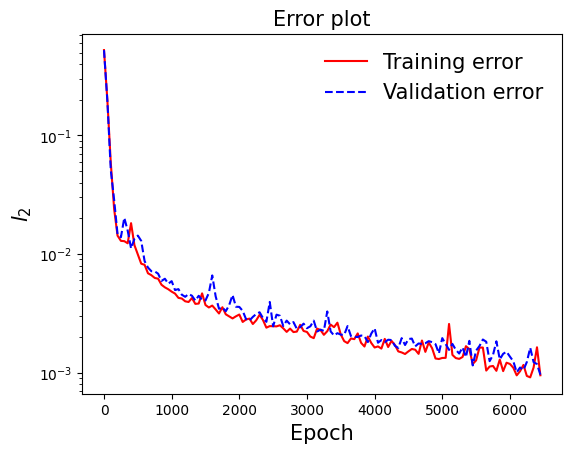

In [42]:
### Plotting the training and the generalization error
fig = plt.figure(1)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title("Error plot",fontsize=15) 
plt.semilogy(Step, T_error,'r',label='Training error')
plt.semilogy(Step, V_error,'b--',label='Validation error')
plt.xlabel('Epoch',fontsize=15)
plt.ylabel(r'$l_2$',fontsize=15)
plt.legend(frameon=False,fontsize=15)

In [43]:
### Defining SINN model 
net7 = SINN(1, 32, 2, 1,'LSTM').to(device)
optimizer = optim.Adam(net7.parameters(), lr=1e-3)

In [44]:
%%time
# Training SINN
T_error=[]
V_error=[]
Step=[]
for step in range(20000):
    optimizer.zero_grad()
    ini = np.random.randn(2*sec_length,batch).astype(np.float32) 
    input = torch.from_numpy(ini.reshape(2*sec_length, batch,1)).to(device)
    prediction, _ = net7(input)
    prediction = prediction[-LAGS:,:,:]
    loss = loss_acf_bruteforce(prediction) + loss_pdf_exact(prediction) + loss_acf_q2(prediction**2)
    loss.backward()
    optimizer.step()
    if step % 50 == 0: 
        with torch.no_grad():
            pred_val, _ = net7(val_set)
            pred_val = pred_val[-LAGS:,:,:]
            loss_val = loss_acf_bruteforce(pred_val)+ loss_pdf_exact(pred_val) + loss_acf_q2(pred_val**2)
            loss_val_acf = loss_acf_fft(pred_val)
            print('[%d]-th step loss: %.3f, %.3f' % (step, loss, loss_val))
            T_error.append(loss.detach().cpu().numpy())
            V_error.append(loss_val.detach().cpu().numpy())
            Step.append(step)
    if loss<=0.05 and loss_val<=0.05:
        optimizer = optim.Adam(net7.parameters(), lr=0.3*1e-3) 
    if loss<=0.01 and loss_val<=0.01:
        optimizer = optim.Adam(net7.parameters(), lr=1e-4)    
    if loss<=0.005 and loss_val<=0.005:
        optimizer = optim.Adam(net7.parameters(), lr=0.3*1e-4)
    if loss<=0.001 and loss_val<=0.001:
            break
print('Training finished')

[0]-th step loss: 0.522, 0.521
[50]-th step loss: 0.328, 0.349
[100]-th step loss: 0.186, 0.180
[150]-th step loss: 0.160, 0.155
[200]-th step loss: 0.327, 0.320
[250]-th step loss: 0.194, 0.191
[300]-th step loss: 0.254, 0.254
[350]-th step loss: 0.179, 0.171
[400]-th step loss: 0.142, 0.140
[450]-th step loss: 0.195, 0.190
[500]-th step loss: 0.156, 0.157
[550]-th step loss: 0.143, 0.141
[600]-th step loss: 0.095, 0.087
[650]-th step loss: 0.041, 0.039
[700]-th step loss: 0.033, 0.040
[750]-th step loss: 0.030, 0.039
[800]-th step loss: 0.026, 0.037
[850]-th step loss: 0.025, 0.035
[900]-th step loss: 0.024, 0.026
[950]-th step loss: 0.016, 0.041
[1000]-th step loss: 0.035, 0.021
[1050]-th step loss: 0.025, 0.025
[1100]-th step loss: 0.019, 0.027
[1150]-th step loss: 0.020, 0.028
[1200]-th step loss: 0.020, 0.019
[1250]-th step loss: 0.019, 0.027
[1300]-th step loss: 0.021, 0.021
[1350]-th step loss: 0.014, 0.029
[1400]-th step loss: 0.019, 0.021
[1450]-th step loss: 0.018, 0.026
[15

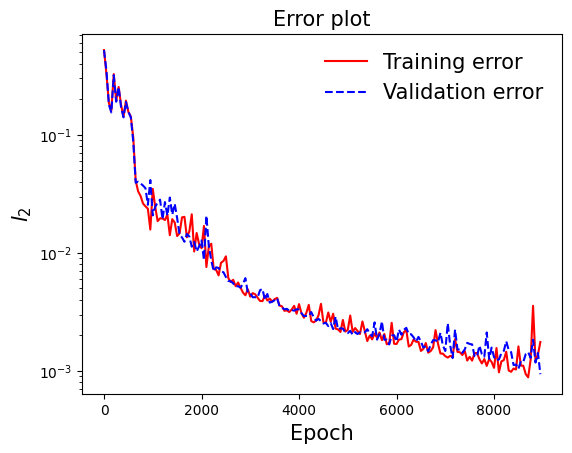

In [45]:
### Plotting the training and the generalization error
fig = plt.figure(1)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title("Error plot",fontsize=15) 
plt.semilogy(Step, T_error,'r',label='Training error')
plt.semilogy(Step, V_error,'b--',label='Validation error')
plt.xlabel('Epoch',fontsize=15)
plt.ylabel(r'$l_2$',fontsize=15)
plt.legend(frameon=False,fontsize=15)

In [46]:
### Defining SINN model 
net8 = SINN(1, 32, 2, 1,'LSTM').to(device)
optimizer = optim.Adam(net8.parameters(), lr=1e-3)

In [47]:
%%time
# Training SINN
T_error=[]
V_error=[]
Step=[]
for step in range(20000):
    optimizer.zero_grad()
    ini = np.random.randn(2*sec_length,batch).astype(np.float32) 
    input = torch.from_numpy(ini.reshape(2*sec_length, batch,1)).to(device)
    prediction, _ = net8(input)
    prediction = prediction[-LAGS:,:,:]
    loss = loss_acf_bruteforce(prediction) + loss_pdf_exact(prediction) + loss_acf_q2(prediction**2)
    loss.backward()
    optimizer.step()
    if step % 50 == 0: 
        with torch.no_grad():
            pred_val, _ = net8(val_set)
            pred_val = pred_val[-LAGS:,:,:]
            loss_val = loss_acf_bruteforce(pred_val)+ loss_pdf_exact(pred_val) + loss_acf_q2(pred_val**2)
            loss_val_acf = loss_acf_fft(pred_val)
            print('[%d]-th step loss: %.3f, %.3f' % (step, loss, loss_val))
            T_error.append(loss.detach().cpu().numpy())
            V_error.append(loss_val.detach().cpu().numpy())
            Step.append(step)
    if loss<=0.05 and loss_val<=0.05:
        optimizer = optim.Adam(net8.parameters(), lr=0.3*1e-3) 
    if loss<=0.01 and loss_val<=0.01:
        optimizer = optim.Adam(net8.parameters(), lr=1e-4)    
    if loss<=0.005 and loss_val<=0.005:
        optimizer = optim.Adam(net8.parameters(), lr=0.3*1e-4)
    if loss<=0.001 and loss_val<=0.001:
            break
print('Training finished')

[0]-th step loss: 0.521, 0.520
[50]-th step loss: 0.326, 0.325
[100]-th step loss: 0.189, 0.182
[150]-th step loss: 0.120, 0.102
[200]-th step loss: 0.333, 0.334
[250]-th step loss: 0.311, 0.302
[300]-th step loss: 0.266, 0.264
[350]-th step loss: 0.172, 0.169
[400]-th step loss: 0.154, 0.133
[450]-th step loss: 0.180, 0.188
[500]-th step loss: 0.083, 0.077
[550]-th step loss: 0.023, 0.042
[600]-th step loss: 0.017, 0.015
[650]-th step loss: 0.016, 0.014
[700]-th step loss: 0.012, 0.014
[750]-th step loss: 0.015, 0.012
[800]-th step loss: 0.012, 0.012
[850]-th step loss: 0.009, 0.037
[900]-th step loss: 0.009, 0.017
[950]-th step loss: 0.010, 0.012
[1000]-th step loss: 0.011, 0.007
[1050]-th step loss: 0.006, 0.011
[1100]-th step loss: 0.015, 0.008
[1150]-th step loss: 0.005, 0.005
[1200]-th step loss: 0.005, 0.008
[1250]-th step loss: 0.008, 0.004
[1300]-th step loss: 0.004, 0.006
[1350]-th step loss: 0.004, 0.004
[1400]-th step loss: 0.005, 0.005
[1450]-th step loss: 0.004, 0.004
[15

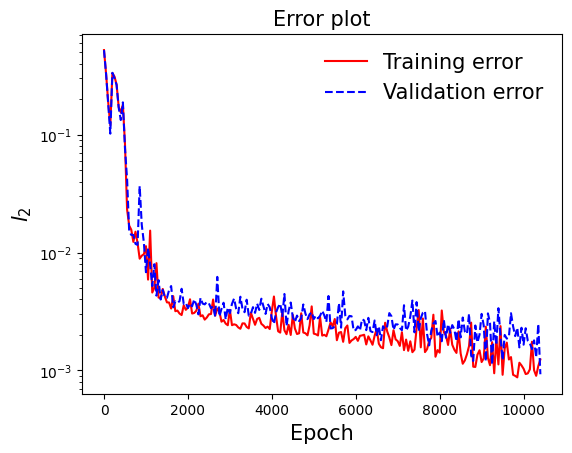

In [48]:
### Plotting the training and the generalization error
fig = plt.figure(1)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title("Error plot",fontsize=15) 
plt.semilogy(Step, T_error,'r',label='Training error')
plt.semilogy(Step, V_error,'b--',label='Validation error')
plt.xlabel('Epoch',fontsize=15)
plt.ylabel(r'$l_2$',fontsize=15)
plt.legend(frameon=False,fontsize=15)

In [49]:
### Defining SINN model 
net9 = SINN(1, 32, 2, 1,'LSTM').to(device)
optimizer = optim.Adam(net9.parameters(), lr=1e-3)

In [50]:
%%time
# Training SINN
T_error=[]
V_error=[]
Step=[]
for step in range(20000):
    optimizer.zero_grad()
    ini = np.random.randn(2*sec_length,batch).astype(np.float32) 
    input = torch.from_numpy(ini.reshape(2*sec_length, batch,1)).to(device)
    prediction, _ = net9(input)
    prediction = prediction[-LAGS:,:,:]
    loss = loss_acf_bruteforce(prediction) + loss_pdf_exact(prediction) + loss_acf_q2(prediction**2)
    loss.backward()
    optimizer.step()
    if step % 50 == 0: 
        with torch.no_grad():
            pred_val, _ = net9(val_set)
            pred_val = pred_val[-LAGS:,:,:]
            loss_val = loss_acf_bruteforce(pred_val)+ loss_pdf_exact(pred_val) + loss_acf_q2(pred_val**2)
            loss_val_acf = loss_acf_fft(pred_val)
            print('[%d]-th step loss: %.3f, %.3f' % (step, loss, loss_val))
            T_error.append(loss.detach().cpu().numpy())
            V_error.append(loss_val.detach().cpu().numpy())
            Step.append(step)
    if loss<=0.05 and loss_val<=0.05:
        optimizer = optim.Adam(net9.parameters(), lr=0.3*1e-3) 
    if loss<=0.01 and loss_val<=0.01:
        optimizer = optim.Adam(net9.parameters(), lr=1e-4)    
    if loss<=0.005 and loss_val<=0.005:
        optimizer = optim.Adam(net9.parameters(), lr=0.3*1e-4)
    if loss<=0.001 and loss_val<=0.001:
            break
print('Training finished')

[0]-th step loss: 0.524, 0.523
[50]-th step loss: 0.121, 0.114
[100]-th step loss: 0.094, 0.083
[150]-th step loss: 0.023, 0.029
[200]-th step loss: 0.021, 0.025
[250]-th step loss: 0.023, 0.020
[300]-th step loss: 0.018, 0.019
[350]-th step loss: 0.015, 0.016
[400]-th step loss: 0.014, 0.015
[450]-th step loss: 0.016, 0.014
[500]-th step loss: 0.011, 0.010
[550]-th step loss: 0.008, 0.008
[600]-th step loss: 0.007, 0.007
[650]-th step loss: 0.006, 0.008
[700]-th step loss: 0.006, 0.007
[750]-th step loss: 0.005, 0.005
[800]-th step loss: 0.005, 0.005
[850]-th step loss: 0.004, 0.006
[900]-th step loss: 0.005, 0.006
[950]-th step loss: 0.004, 0.004
[1000]-th step loss: 0.003, 0.004
[1050]-th step loss: 0.003, 0.004
[1100]-th step loss: 0.003, 0.004
[1150]-th step loss: 0.003, 0.004
[1200]-th step loss: 0.004, 0.003
[1250]-th step loss: 0.003, 0.004
[1300]-th step loss: 0.003, 0.003
[1350]-th step loss: 0.003, 0.003
[1400]-th step loss: 0.002, 0.003
[1450]-th step loss: 0.002, 0.003
[15

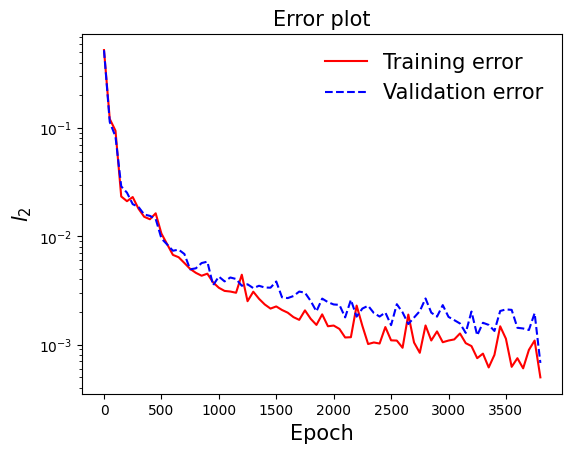

In [51]:
### Plotting the training and the generalization error
fig = plt.figure(1)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title("Error plot",fontsize=15) 
plt.semilogy(Step, T_error,'r',label='Training error')
plt.semilogy(Step, V_error,'b--',label='Validation error')
plt.xlabel('Epoch',fontsize=15)
plt.ylabel(r'$l_2$',fontsize=15)
plt.legend(frameon=False,fontsize=15)

# END